In [1]:
import math
from glob import glob
import seaborn as sns
from torchsummary import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader

from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from sklearn.metrics import cohen_kappa_score
import torch.nn.functional as F
import cv2
import umap
import gc
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torchvision.models as models
#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

In [3]:
orig_dir   = './larvae'
nclasses   = 2

width       = 224
height      = 224
nchannels   = 3
maxval      = 255.
input_shape = (nchannels,height,width)

data = glob(orig_dir+"/*.png")

# Extract labels from filenames (0 for class 1, 1 for class 2)
# This is crucial for the 'stratify' parameter
labels = [int(f.split('/')[-1].split('_')[0]) - 1 for f in data]

# The 'stratify=labels' argument ensures both sets have the same class proportion
train_val_files, testset, train_val_labels, _ = train_test_split(
    data, labels, test_size=0.30, random_state=42, stratify=labels)

# now we split the temporary 70% set into the final training and validation sets.
# The validation set is 0.20 of the original total, which is 0.20/0.70 of this temporary set.
val_size_relative = 0.20 / (0.50 + 0.20)
trainset, validset, _, _ = train_test_split(
    train_val_files, train_val_labels, test_size=val_size_relative, random_state=42, stratify=train_val_labels)


# verifying
print(f"Total: {len(data)}")
print(f"Training: {len(trainset)}")
print(f"Validation: {len(validset)}")
print(f"Test: {len(testset)}")

# Set output model name
model_name  = 'Larvae_v3.pth'

Total: 1598
Training: 798
Validation: 320
Test: 480


In [4]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.

prep = transforms.Compose([
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation,
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 3
# of epochs, we are actually implementing data augmentation.

aug = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)
    def __getitem__(self, ix): # returns the item at position ix
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()
        return(image,target)

In [5]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

Number of images: 798
Images are 224x224x3
Class of the image:  1


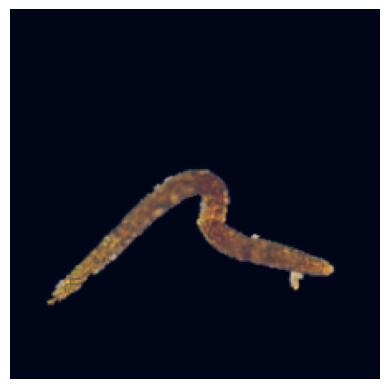

In [6]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[14] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
plt.axis('off')
print("Class of the image: ", target+1)
plt.show()

In [7]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload)) # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

Adding Residual Blocks to the net

In [7]:
# import gc
# del trainset, validset, testset
# gc.collect()
# torch.cuda.empty_cache()

In [8]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long())
    # add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

In [9]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

In [38]:
def Test(model, dataload, criterion, device):
    N = len(dataload)
    mean_loss = 0
    mean_acc  = 0

    all_predictions = []
    all_targets = []

    # Set the model to evaluation mode
    model.eval()
    # Disabling gradient
    with torch.no_grad():
        for bx, data in enumerate(dataload):
            # This part calculates the loss and accuracy per batch, which we will average
            loss, acc  = validate_batch(model, data, criterion, device)
            mean_loss += loss
            mean_acc  += acc

            ims, targets = data
            ims, targets = ims.to(device), targets.to(device)

            preds = model(ims)
            pred_labels = torch.max(preds, 1)[1]

            all_predictions.extend(pred_labels.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate the final average metrics
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    kappa = cohen_kappa_score(all_targets, all_predictions)

    # Return all three metrics
    return(mean_loss, mean_acc, kappa)

In [21]:
def train_model(model, optimizer, scheduler, criterion,
                train_loader, val_loader, device,
                n_epochs=100, patience=10):


    # initialization
    log = Report(n_epochs)
    patience_counter = 0
    best_val_loss = float('inf')
    best_model_weights = None

    print("--- Starting Training ---")
    # --- Main training loop ---
    for ex in range(n_epochs):

        # training phase
        model.train() # Set model to training mode
        running_trn_loss = 0.0
        running_trn_acc = 0.0
        N = len(train_loader)
        for bx, data in enumerate(train_loader):
            loss, acc = train_batch(model, data, optimizer, criterion, device)
            running_trn_loss += loss
            running_trn_acc += acc
            log.record((ex + (bx + 1) / N), trn_loss=loss, trn_acc=acc, end='\r')

        epoch_trn_loss = running_trn_loss / N
        epoch_trn_acc = running_trn_acc / N

        # validation phase
        model.eval()
        running_val_loss = 0.0
        running_val_acc = 0.0
        N_val = len(val_loader)
        val_preds_list = []
        val_targets_list = []

        with torch.no_grad():
            for bx, data in enumerate(val_loader):
                loss, acc = validate_batch(model, data, criterion, device)
                running_val_loss += loss
                running_val_acc += acc
                log.record((ex + (bx + 1) / N_val), val_loss=loss, val_acc=acc, end='\r')

                ims, targets = data
                ims, targets = ims.to(device), targets.to(device)
                preds = model(ims)
                pred_labels = torch.max(preds, 1)[1]
                val_preds_list.extend(pred_labels.cpu().numpy())
                val_targets_list.extend(targets.cpu().numpy())

        epoch_val_loss = running_val_loss / N_val
        epoch_val_acc = running_val_acc / N_val
        kappa = cohen_kappa_score(val_targets_list, val_preds_list)
        log.record(ex + 1, val_kappa=kappa, end='\r')

        # reporting and early Stopping ---
        if (ex + 1) % 5 == 0:
            print(f"EPOCH: {ex+1}  ",
                  f"Trn_Loss: {epoch_trn_loss:.4f}  ",
                  f"Trn_Acc: {epoch_trn_acc:.4f}  ",
                  f"Val_Loss: {epoch_val_loss:.4f}  ",
                  f"Val_Acc: {epoch_val_acc:.4f}  ",
                  f"Val_Kappa: {kappa:.4f}  ",
                  f"Patience: {patience_counter}/{patience}")

        scheduler.step()

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement.")
            break


    if best_model_weights:
        print("\nLoading best model weights found during training.")
        model.load_state_dict(best_model_weights)

    print("\n--- Training finished ---")
    return model, log

# Residual Model

In [23]:
class ResidualBlock(nn.Module):
    """
    A residual block with two convolutional layers.
    Includes a shortcut connection that adds the input to the output.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # main path will have two convolutions
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv_block(x) + self.shortcut(x)
        out = self.relu(out)
        return out

class LarvaNetV3(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(LarvaNetV3, self).__init__()

        self.in_channels = 64


        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape[0], self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True)
        )
        # 224 -> (conv) -> 112


        self.layer1 = self._make_layer(ResidualBlock, 64, num_blocks=2, stride=1)  # 112x112 -> 112x112
        self.layer2 = self._make_layer(ResidualBlock, 128, num_blocks=2, stride=2) # 112x112 -> 56x56
        self.layer3 = self._make_layer(ResidualBlock, 256, num_blocks=2, stride=2) # 56x56  -> 28x28
        self.layer4 = self._make_layer(ResidualBlock, 512, num_blocks=2, stride=2) # 28x28  -> 14x14

        pool_output_size = 11
        self.avgpool = nn.AdaptiveAvgPool2d((pool_output_size, pool_output_size))

        final_channels = 512

        flattened_features = final_channels * pool_output_size * pool_output_size # 512 * 3 * 3 = 4608

        self.classifier = nn.Sequential(
            nn.Linear(in_features=flattened_features, out_features=128, bias=True), # usei 128, pode ser 64
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )


    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [24]:
# --- Instantiate and summarize the new model ---
model_v3 = LarvaNetV3(input_shape, nclasses).to(device)
summary(model_v3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          36,864
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          36,864
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
    ResidualBlock-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,864
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
           Conv2d-14         [-1, 64, 1

In [25]:
optimizer_v3    = optim.Adam(model_v3.parameters(), lr=1e-5, weight_decay=1e-5)
lr_scheduler_v3 = optim.lr_scheduler.StepLR(optimizer_v3, step_size=33, gamma=0.9)

In [26]:
model_v3, log = train_model(model_v3, optimizer_v3, lr_scheduler_v3, criterion, train_loader=trainload, val_loader=validload, device=device, patience=100)

--- Starting Training ---
EPOCH: 5.000  val_kappa: 0.033  (71.99s - 1367.72s remaining)EPOCH: 5   Trn_Loss: 0.3789   Trn_Acc: 0.8646   Val_Loss: 0.4009   Val_Acc: 0.8469   Val_Kappa: 0.0333   Patience: 0/100
EPOCH: 10.000  val_kappa: 0.617  (142.37s - 1281.37s remaining)EPOCH: 10   Trn_Loss: 0.2619   Trn_Acc: 0.9186   Val_Loss: 0.2685   Val_Acc: 0.9187   Val_Kappa: 0.6169   Patience: 0/100
EPOCH: 15.000  val_kappa: 0.706  (213.09s - 1207.49s remaining)EPOCH: 15   Trn_Loss: 0.1821   Trn_Acc: 0.9549   Val_Loss: 0.2705   Val_Acc: 0.9344   Val_Kappa: 0.7055   Patience: 0/100
EPOCH: 20.000  val_kappa: 0.635  (283.81s - 1135.25s remaining)EPOCH: 20   Trn_Loss: 0.1418   Trn_Acc: 0.9712   Val_Loss: 0.3738   Val_Acc: 0.9219   Val_Kappa: 0.6354   Patience: 0/100
EPOCH: 25.000  val_kappa: 0.786  (353.86s - 1061.59s remaining)EPOCH: 25   Trn_Loss: 0.1731   Trn_Acc: 0.9512   Val_Loss: 0.2656   Val_Acc: 0.9469   Val_Kappa: 0.7863   Patience: 5/100
EPOCH: 30.000  val_kappa: 0.773  (423.93s - 989.17s 

100%|██████████| 201/201 [00:00<00:00, 2938.53it/s]


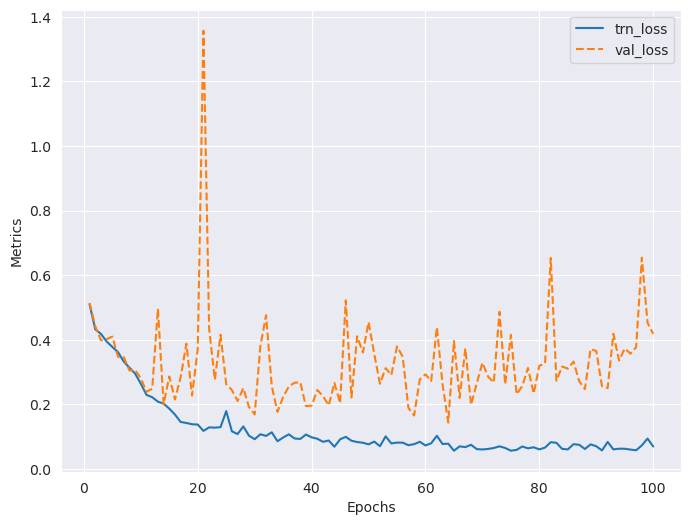

100%|██████████| 201/201 [00:00<00:00, 3025.56it/s]


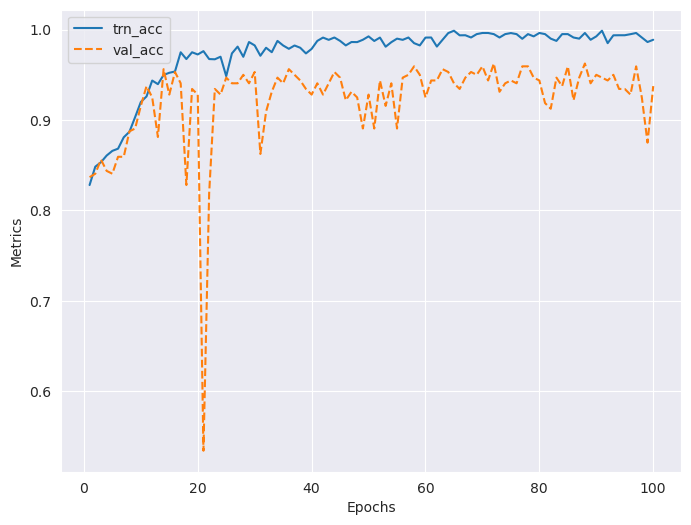

In [27]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

In [29]:
# The function now returns three values
(loss, acc, kappa) = Test(model_v3, testload, criterion, device)

print('Test Results -> Loss: {:.6f}  Acc: {:.6f}  Kappa: {:.6f}'.format(loss, acc, kappa))

Test Results -> Loss: 0.309235  Acc: 0.937500  Kappa: 0.712735


# Inception Model 1

In [13]:

# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(5, 5),
                  stride=1, padding=2, bias=False),
        #defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class InceptionModule(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super(InceptionModule, self).__init__()
        # 1x1 convolution branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels, c1, kernel_size=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True)
        )
        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels, c2[0], kernel_size=1),
            nn.BatchNorm2d(c2[0]),
            nn.ReLU(inplace=True),
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1]),
            nn.ReLU(inplace=True)
        )
        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_channels, c3[0], kernel_size=1),
            nn.BatchNorm2d(c3[0]),
            nn.ReLU(inplace=True),
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1]),
            nn.ReLU(inplace=True)
        )
        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, c4, kernel_size=1),
            nn.BatchNorm2d(c4),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        # concatenates the outputs along the channel dimension
        return torch.cat([y1, y2, y3, y4], 1)

class LarvaNetV4(nn.Module):
    # using Inception-style modules for better generalization.

    def __init__(self, input_shape, num_classes):
        super(LarvaNetV4, self).__init__()

        # Initial convolutional block to process the input image
        self.conv1 = conv_block(input_shape[0], 64, stride_val=2) # Output: 112x112
        self.conv2 = conv_block(64, 128, stride_val=2)            # Output: 56x56

        # Stacking two Inception modules
        self.inception1 = InceptionModule(128, c1=64, c2=(32,64), c3=(16,32), c4=32)
        # The input channels for the next layer is the sum of the outputs of the previous one
        # 64 + 64 + 32 + 32 = 192
        self.inception2 = InceptionModule(192, c1=64, c2=(48,96), c3=(24,48), c4=48)
        # Output channels: 64 + 96 + 48 + 48 = 256

        # Max pooling to reduce dimensions before classifier
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 56x56 -> 28x28

        # Global pooling and final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [14]:
model_v4 = LarvaNetV4(input_shape, nclasses).to(device)
summary(model_v4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           4,800
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]         204,800
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           8,256
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 32, 56, 56]           4,128
      BatchNorm2d-13           [-1, 32, 56, 56]              64
             ReLU-14           [-1, 32,

In [19]:
optimizer_v4    = optim.Adam(model_v4.parameters(), lr=1e-5)
lr_scheduler_v4 = optim.lr_scheduler.StepLR(optimizer_v4, step_size=33, gamma=0.9)

In [22]:
model_v4, log = train_model(model_v4, optimizer_v4, lr_scheduler_v4, criterion, train_loader=trainload, val_loader=validload, device=device, patience=100)

--- Starting Training ---
EPOCH: 5.000  val_kappa: 0.000  (54.42s - 1034.01s remaining)EPOCH: 5   Trn_Loss: 0.4557   Trn_Acc: 0.8458   Val_Loss: 0.4565   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 0/100
EPOCH: 10.000  val_kappa: 0.000  (109.00s - 980.98s remaining)EPOCH: 10   Trn_Loss: 0.4135   Trn_Acc: 0.8458   Val_Loss: 0.4162   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 0/100
EPOCH: 15.000  val_kappa: 0.000  (163.73s - 927.81s remaining)EPOCH: 15   Trn_Loss: 0.3768   Trn_Acc: 0.8458   Val_Loss: 0.3843   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 0/100
EPOCH: 20.000  val_kappa: 0.243  (218.57s - 874.27s remaining)EPOCH: 20   Trn_Loss: 0.3394   Trn_Acc: 0.8623   Val_Loss: 0.3450   Val_Acc: 0.8688   Val_Kappa: 0.2432   Patience: 0/100
EPOCH: 25.000  val_kappa: 0.539  (272.88s - 818.63s remaining)EPOCH: 25   Trn_Loss: 0.2859   Trn_Acc: 0.9048   Val_Loss: 0.3043   Val_Acc: 0.9062   Val_Kappa: 0.5393   Patience: 0/100
EPOCH: 30.000  val_kappa: 0.519  (327.93s - 765.16s rema

100%|██████████| 201/201 [00:00<00:00, 5090.82it/s]


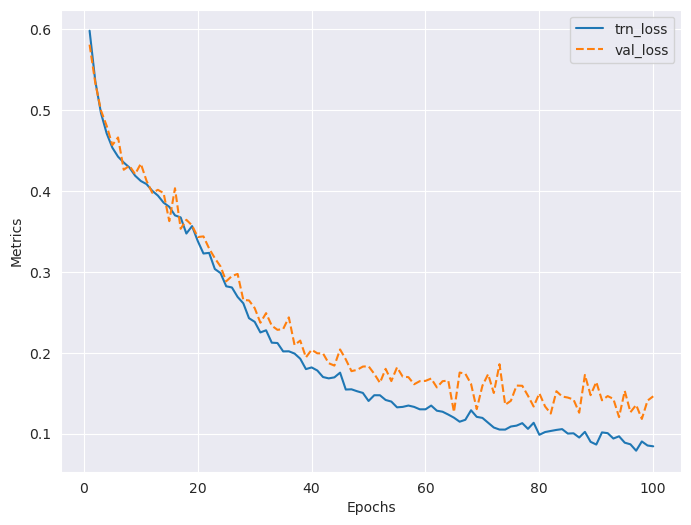

100%|██████████| 201/201 [00:00<00:00, 4780.69it/s]


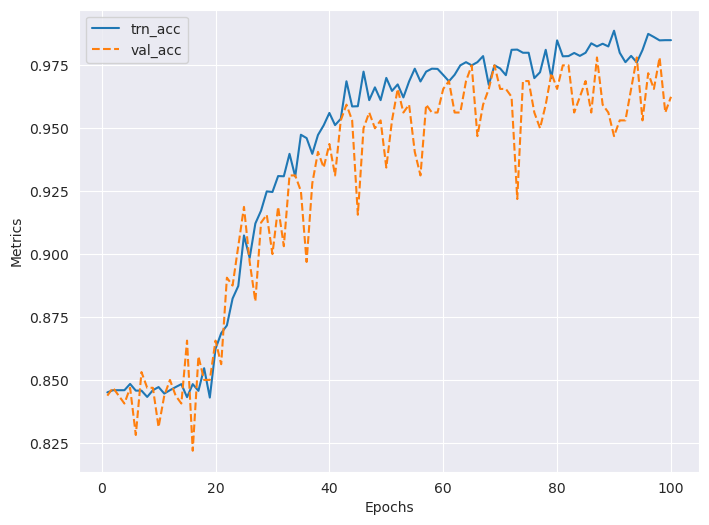

In [24]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

In [23]:
# The function now returns three values
(loss, acc, kappa) = Test(model_v4, testload, criterion, device)

print('Test Results -> Loss: {:.6f}  Acc: {:.6f}  Kappa: {:.6f}'.format(loss, acc, kappa))

Test Results -> Loss: 0.127314  Acc: 0.954167  Kappa: 0.799939


# Inception Model 2

In [25]:
class LarvaNetV5(nn.Module):
    """
    A deeper version of the Inception-style network.
    """
    def __init__(self, input_shape, num_classes):
        super(LarvaNetV5, self).__init__()

        # Initial convolutional blocks (same as V4)
        self.conv1 = conv_block(input_shape[0], 64, stride_val=2) # Output: 112x112
        self.conv2 = conv_block(64, 128, stride_val=2)            # Output: 56x56

        # First two Inception modules (same as V4)
        self.inception1 = InceptionModule(128, c1=64, c2=(32,64), c3=(16,32), c4=32)
        # Output channels from inception1: 64 + 64 + 32 + 32 = 192
        self.inception2 = InceptionModule(192, c1=64, c2=(48,96), c3=(24,48), c4=48)
        # Output channels from inception2: 64 + 96 + 48 + 48 = 256

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 56x56 -> 28x28

        self.inception3 = InceptionModule(256, c1=96, c2=(64,128), c3=(32,64), c4=64)

        # Calculate the final number of channels after the last inception module
        # 96 + 128 + 64 + 64 = 384
        final_channels = 96 + 128 + 64 + 64

        # Global pooling and final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(final_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.maxpool(x) # new pooling layer
        x = self.inception3(x) # new inception module
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model_v5 = LarvaNetV5(input_shape, nclasses).to(device)
summary(model_v5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           4,800
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]         204,800
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           8,256
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 32, 56, 56]           4,128
      BatchNorm2d-13           [-1, 32, 56, 56]              64
             ReLU-14           [-1, 32,

In [26]:
optimizer_v5    = optim.Adam(model_v5.parameters(), lr=1e-5)
lr_scheduler_v5 = optim.lr_scheduler.StepLR(optimizer_v5, step_size=33, gamma=0.9)

In [27]:
model_v5, log = train_model(model_v5, optimizer_v5, lr_scheduler_v5, criterion, train_loader=trainload, val_loader=validload, device=device, patience=100)

--- Starting Training ---
EPOCH: 5.000  val_kappa: 0.128  (56.76s - 1078.45s remaining)EPOCH: 5   Trn_Loss: 0.5120   Trn_Acc: 0.8624   Val_Loss: 0.4927   Val_Acc: 0.8562   Val_Kappa: 0.1280   Patience: 0/100
EPOCH: 10.000  val_kappa: 0.433  (113.38s - 1020.45s remaining)EPOCH: 10   Trn_Loss: 0.3892   Trn_Acc: 0.8998   Val_Loss: 0.3856   Val_Acc: 0.8906   Val_Kappa: 0.4326   Patience: 0/100
EPOCH: 15.000  val_kappa: 0.598  (169.89s - 962.70s remaining)EPOCH: 15   Trn_Loss: 0.2959   Trn_Acc: 0.9398   Val_Loss: 0.2842   Val_Acc: 0.9156   Val_Kappa: 0.5981   Patience: 0/100
EPOCH: 20.000  val_kappa: 0.770  (226.68s - 906.73s remaining)EPOCH: 20   Trn_Loss: 0.2253   Trn_Acc: 0.9575   Val_Loss: 0.2408   Val_Acc: 0.9469   Val_Kappa: 0.7705   Patience: 1/100
EPOCH: 25.000  val_kappa: 0.816  (283.34s - 850.01s remaining)EPOCH: 25   Trn_Loss: 0.1945   Trn_Acc: 0.9649   Val_Loss: 0.2036   Val_Acc: 0.9563   Val_Kappa: 0.8161   Patience: 1/100
EPOCH: 30.000  val_kappa: 0.770  (339.91s - 793.11s rem

In [29]:
# The function now returns three values
(loss, acc, kappa) = Test(model_v5, testload, criterion, device)

print('Test Results -> Loss: {:.6f}  Acc: {:.6f}  Kappa: {:.6f}'.format(loss, acc, kappa))

Test Results -> Loss: 0.108105  Acc: 0.981250  Kappa: 0.926063


100%|██████████| 201/201 [00:00<00:00, 5745.27it/s]


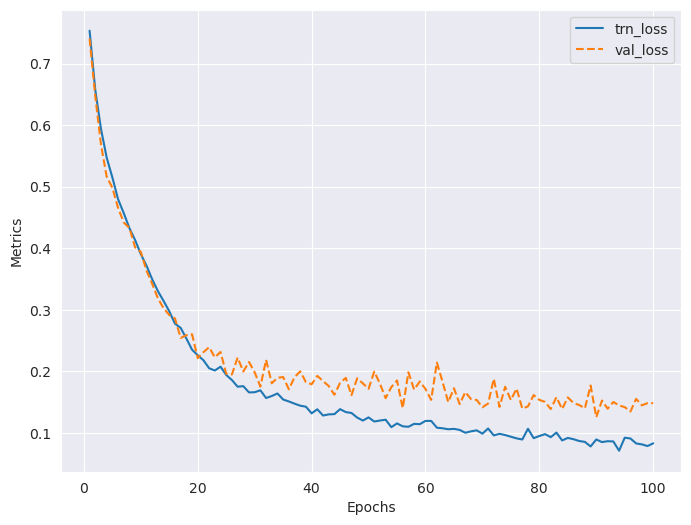

100%|██████████| 201/201 [00:00<00:00, 6262.15it/s]


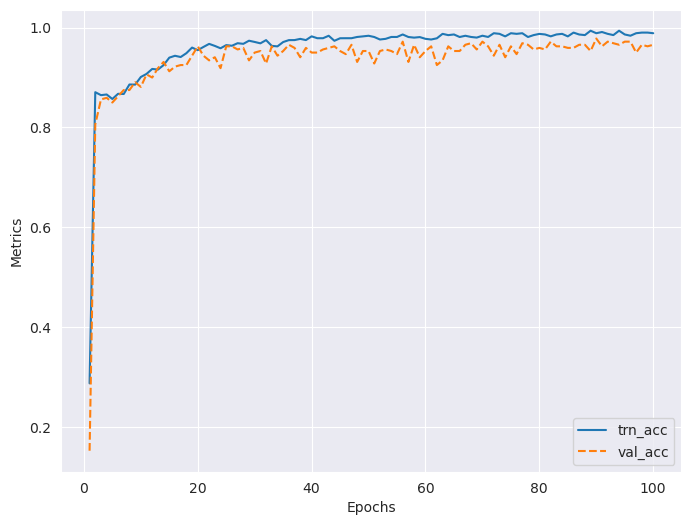

In [28]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

## Evaluating

In [30]:
def visualize_larvae_features(feature_map: torch.Tensor,
                               max_channels: int = 16,
                               start_channel: int = 0,
                               figsize: tuple = (15, 10),
                               sample_idx: int = 0):
    """
    Visualize LarvaNet feature maps

    Args:
        feature_map: Feature map tensor (batch_size, channels, height, width)
        max_channels: Maximum number of channels to display
        start_channel: Starting channel index (0-based)
        figsize: Figure size for matplotlib
        sample_idx: Which sample from the batch to visualize
    """
    if feature_map.dim() == 4:
        feature_map_sample = feature_map[sample_idx]  # Shape: (channels, height, width)
    else:
        feature_map_sample = feature_map

    total_channels = feature_map_sample.shape[0]
    end_channel = min(start_channel + max_channels, total_channels)
    num_channels = end_channel - start_channel

    if start_channel >= total_channels:
        raise ValueError(f"start_channel ({start_channel}) must be less than total channels ({total_channels})")

    print(f"Feature map shape: {feature_map.shape}")
    print(f"Total channels: {total_channels}")
    print(f"Visualizing channels {start_channel}-{end_channel-1} from sample {sample_idx}")

    # new addition: a list to get dead filters
    dead_filter_indices = []

    # Calculate grid dimensions
    cols = 4
    rows = (num_channels + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for i in range(num_channels):
        ax = axes[i]
        channel_idx = start_channel + i
        channel_data = feature_map_sample[channel_idx].cpu().numpy()
        if channel_data.max() == 0:
            dead_filter_indices.append(channel_idx)
        im = ax.imshow(channel_data, cmap='viridis')
        ax.set_title(f'Channel {channel_idx}\nMin: {channel_data.min():.2f}\nMax: {channel_data.max():.2f}',
                    fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.6)

    # Hide unused subplots
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'LarvaNet Feature Maps - Channels {start_channel}-{end_channel-1}\nShape: {feature_map.shape}',
                 fontsize=14)
    plt.tight_layout()
    plt.show()
    print("Analysis for this sample:")
    if dead_filter_indices:
        print(f"Found {len(dead_filter_indices)} dead filters in the visualized range.")
        print(f"Indices: {dead_filter_indices}")
    else:
        print("No dead filters found in the visualized range.")

In [31]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.model.eval()
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, class_idx=None):
        # Forward pass
        model_output = self.model(input_image)

        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1).squeeze()

        # backward pass
        self.model.zero_grad()
        class_score = model_output[:, class_idx]
        class_score.backward(retain_graph=True)
        # get gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Calculate weights
        weights = torch.mean(gradients, dim=[2, 3])

        # Generate CAM
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(input_image.device)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]

        # Apply ReLU and normalize
        cam = F.relu(cam)
        if torch.max(cam) > 0:
            cam = cam - torch.min(cam)
            cam = cam / torch.max(cam)

        return cam.detach().cpu().numpy(), model_output.detach()

def visualize_gradcam(orig_image, cam, alpha=0.4):
    # Resize CAM to match original image size
    cam_resized = cv2.resize(cam, (orig_image.shape[1], orig_image.shape[0]))

    # Create heatmap and overlay it
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed = cv2.addWeighted(orig_image, 1 - alpha, heatmap, alpha, 0)

    return overlayed, heatmap

def denormalize(tensor):
    # These are the means and stds used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # we need to rearrange the tensor dimensions
    tensor = tensor.clone().permute(1, 2, 0)
    tensor = tensor * torch.tensor(std, device=tensor.device) + torch.tensor(mean, device=tensor.device)

    # clip values to be between 0 and 1 and convert to a NumPy array for plotting
    tensor = torch.clamp(tensor, 0, 1)
    return (tensor.cpu().numpy() * 255).astype(np.uint8)




In [32]:
def extract_features(model, dataloader, target_layer_name):
    """
    Extracts features from a specified layer for all samples in the dataloader.
    """
    # Dictionary to store the activations
    activations = {}

    def get_activation(name):
        # Hook function to save the output of a layer
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register the hook to the target layer
    target_layer = dict(model.named_modules())[target_layer_name]
    hook_handle = target_layer.register_forward_hook(get_activation(target_layer_name))

    # --- Loop through the dataloader to collect features and labels ---
    all_features = []
    all_labels = []

    model.to(device)
    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            model(imgs) # Perform forward pass to trigger the hook

            # Get the captured activations
            feature_batch = activations[target_layer_name]

            # For convolutional layers, apply Global Average Pooling to get a feature vector
            if feature_batch.dim() == 4:
                feature_batch = F.adaptive_avg_pool2d(feature_batch, (1, 1)).squeeze()

            all_features.append(feature_batch.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    hook_handle.remove()

    # Concatenate all batches
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels


def plot_projections(features, labels, title):
    """
    Performs UMAP dimensionality reduction and plots the result.
    """
    print(f"Running UMAP for '{title}'...")

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(features)

    print("Plotting results...")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette=sns.color_palette("hls", 2), # Use 2 colors for the 2 classes
        legend="full"
    )
    plt.title(title)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

In [33]:
def plot_tsne_projections(features, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embedding = tsne.fit_transform(features)

    print("Plotting results...")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette=sns.color_palette("hls", 2),
        legend="full"
    )
    plt.title(title)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

In [10]:
# # Visualize activations at the output of the last convolutional block for a given image
# model_v3.load_state_dict(torch.load('Larvae_v3.pth', map_location='cuda'))
# model_v3.to('cuda')

/tmp/ipykernel_92906/1341226132.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v3.load_state_dict(torch.load('Larvae_v3.pth', map_location='cuda'))


LarvaNetV3(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [36]:
target_image, target = trainset[14]
target_image = target_image.unsqueeze(0).to(device)

In [37]:
model_v5.to(device)

LarvaNetV5(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (b1): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momen

Targeting 'inception1' to see higher-resolution feature maps...
Feature map shape: torch.Size([1, 192, 56, 56])
Total channels: 192
Visualizing channels 0-15 from sample 0


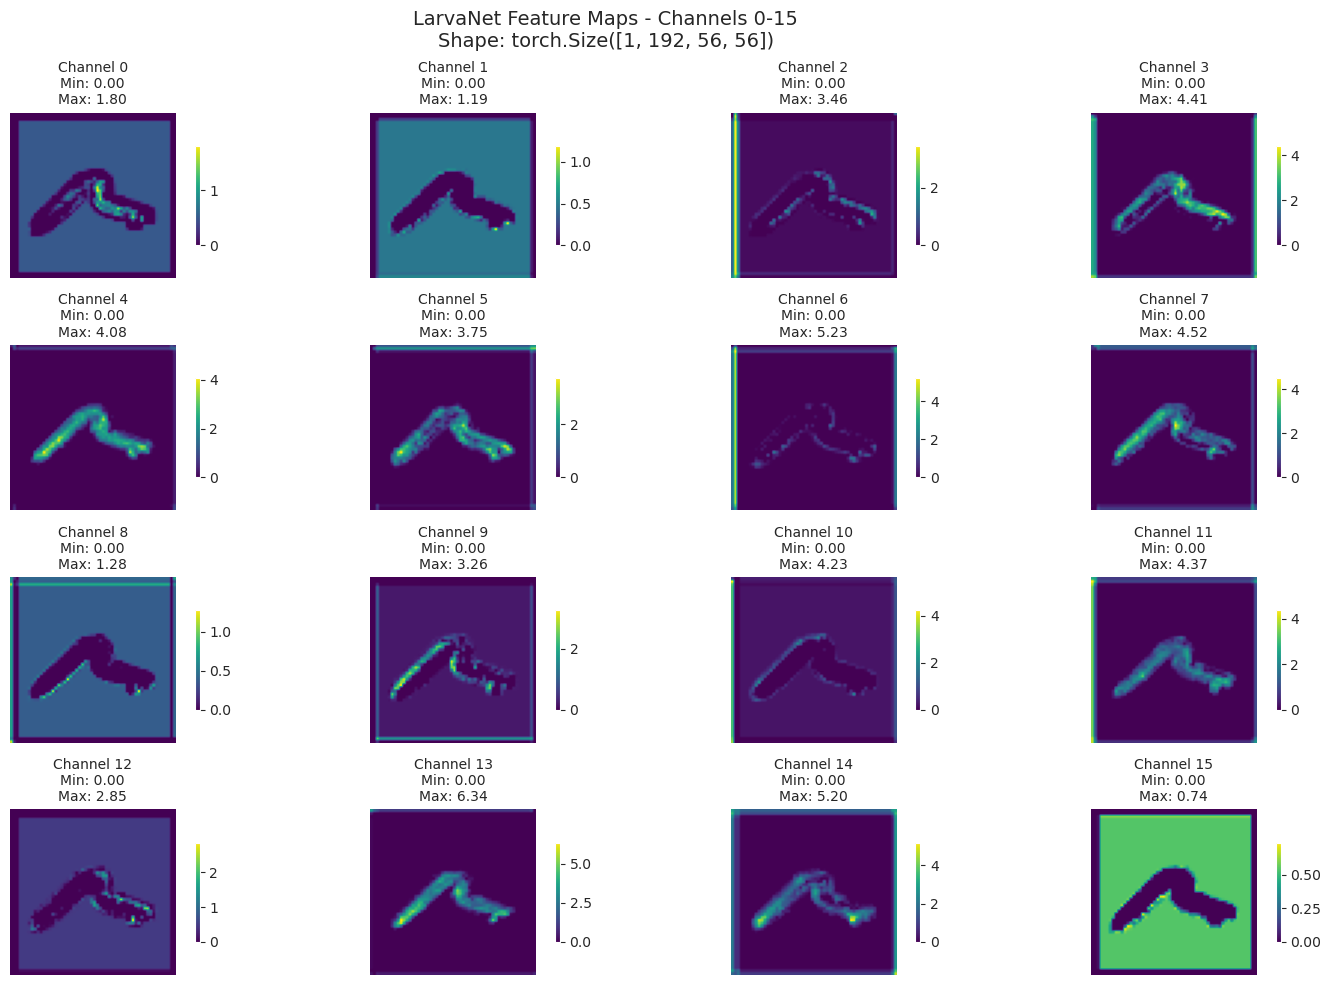

Analysis for this sample:
No dead filters found in the visualized range.


In [40]:

activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_v5.eval()

print("Targeting 'inception1' to see higher-resolution feature maps...")
target_layer = model_v5.inception1
hook_handle = target_layer.register_forward_hook(get_activation('inception1_output'))

with torch.no_grad():
    _ = model_v5(target_image)

# Remove the hook
hook_handle.remove()

featmap = activations['inception1_output']

visualize_larvae_features(featmap, max_channels=16, start_channel=0)

In [42]:
print("Finding examples in the train set...")
# Indices for: True Positive, False Negative, True Negative, False Positive
tp_idx, fn_idx, tn_idx, fp_idx = -1, -1, -1, -1

model_v5.eval()
with torch.no_grad():
    for i, (img_tensor, label) in enumerate(testset):
        img_tensor_batch = img_tensor.unsqueeze(0).to(device)
        output = model_v5(img_tensor_batch)
        prediction = torch.argmax(output, dim=1).item()

        # Case: True label is Larva (0)
        if label == 0:
            if prediction == 0 and tp_idx == -1:
                tp_idx = i
            elif prediction == 1 and fn_idx == -1:
                fn_idx = i

        # Case: True label is Impurity (1)
        elif label == 1:
            if prediction == 1 and tn_idx == -1:
                tn_idx = i
            elif prediction == 0 and fp_idx == -1:
                fp_idx = i

        # Stop when all four examples are found
        if all(idx != -1 for idx in [tp_idx, fn_idx, tn_idx, fp_idx]):
            break

print(f"True Positive (Larva as Larva) found at index: {tp_idx}")
print(f"False Negative (Larva as Impurity) found at index: {fn_idx}")
print(f"True Negative (Impurity as Impurity) found at index: {tn_idx}")
print(f"False Positive (Impurity as Larva) found at index: {fp_idx}")

Finding examples in the train set...
True Positive (Larva as Larva) found at index: 4
False Negative (Larva as Impurity) found at index: 14
True Negative (Impurity as Impurity) found at index: 0
False Positive (Impurity as Larva) found at index: 222


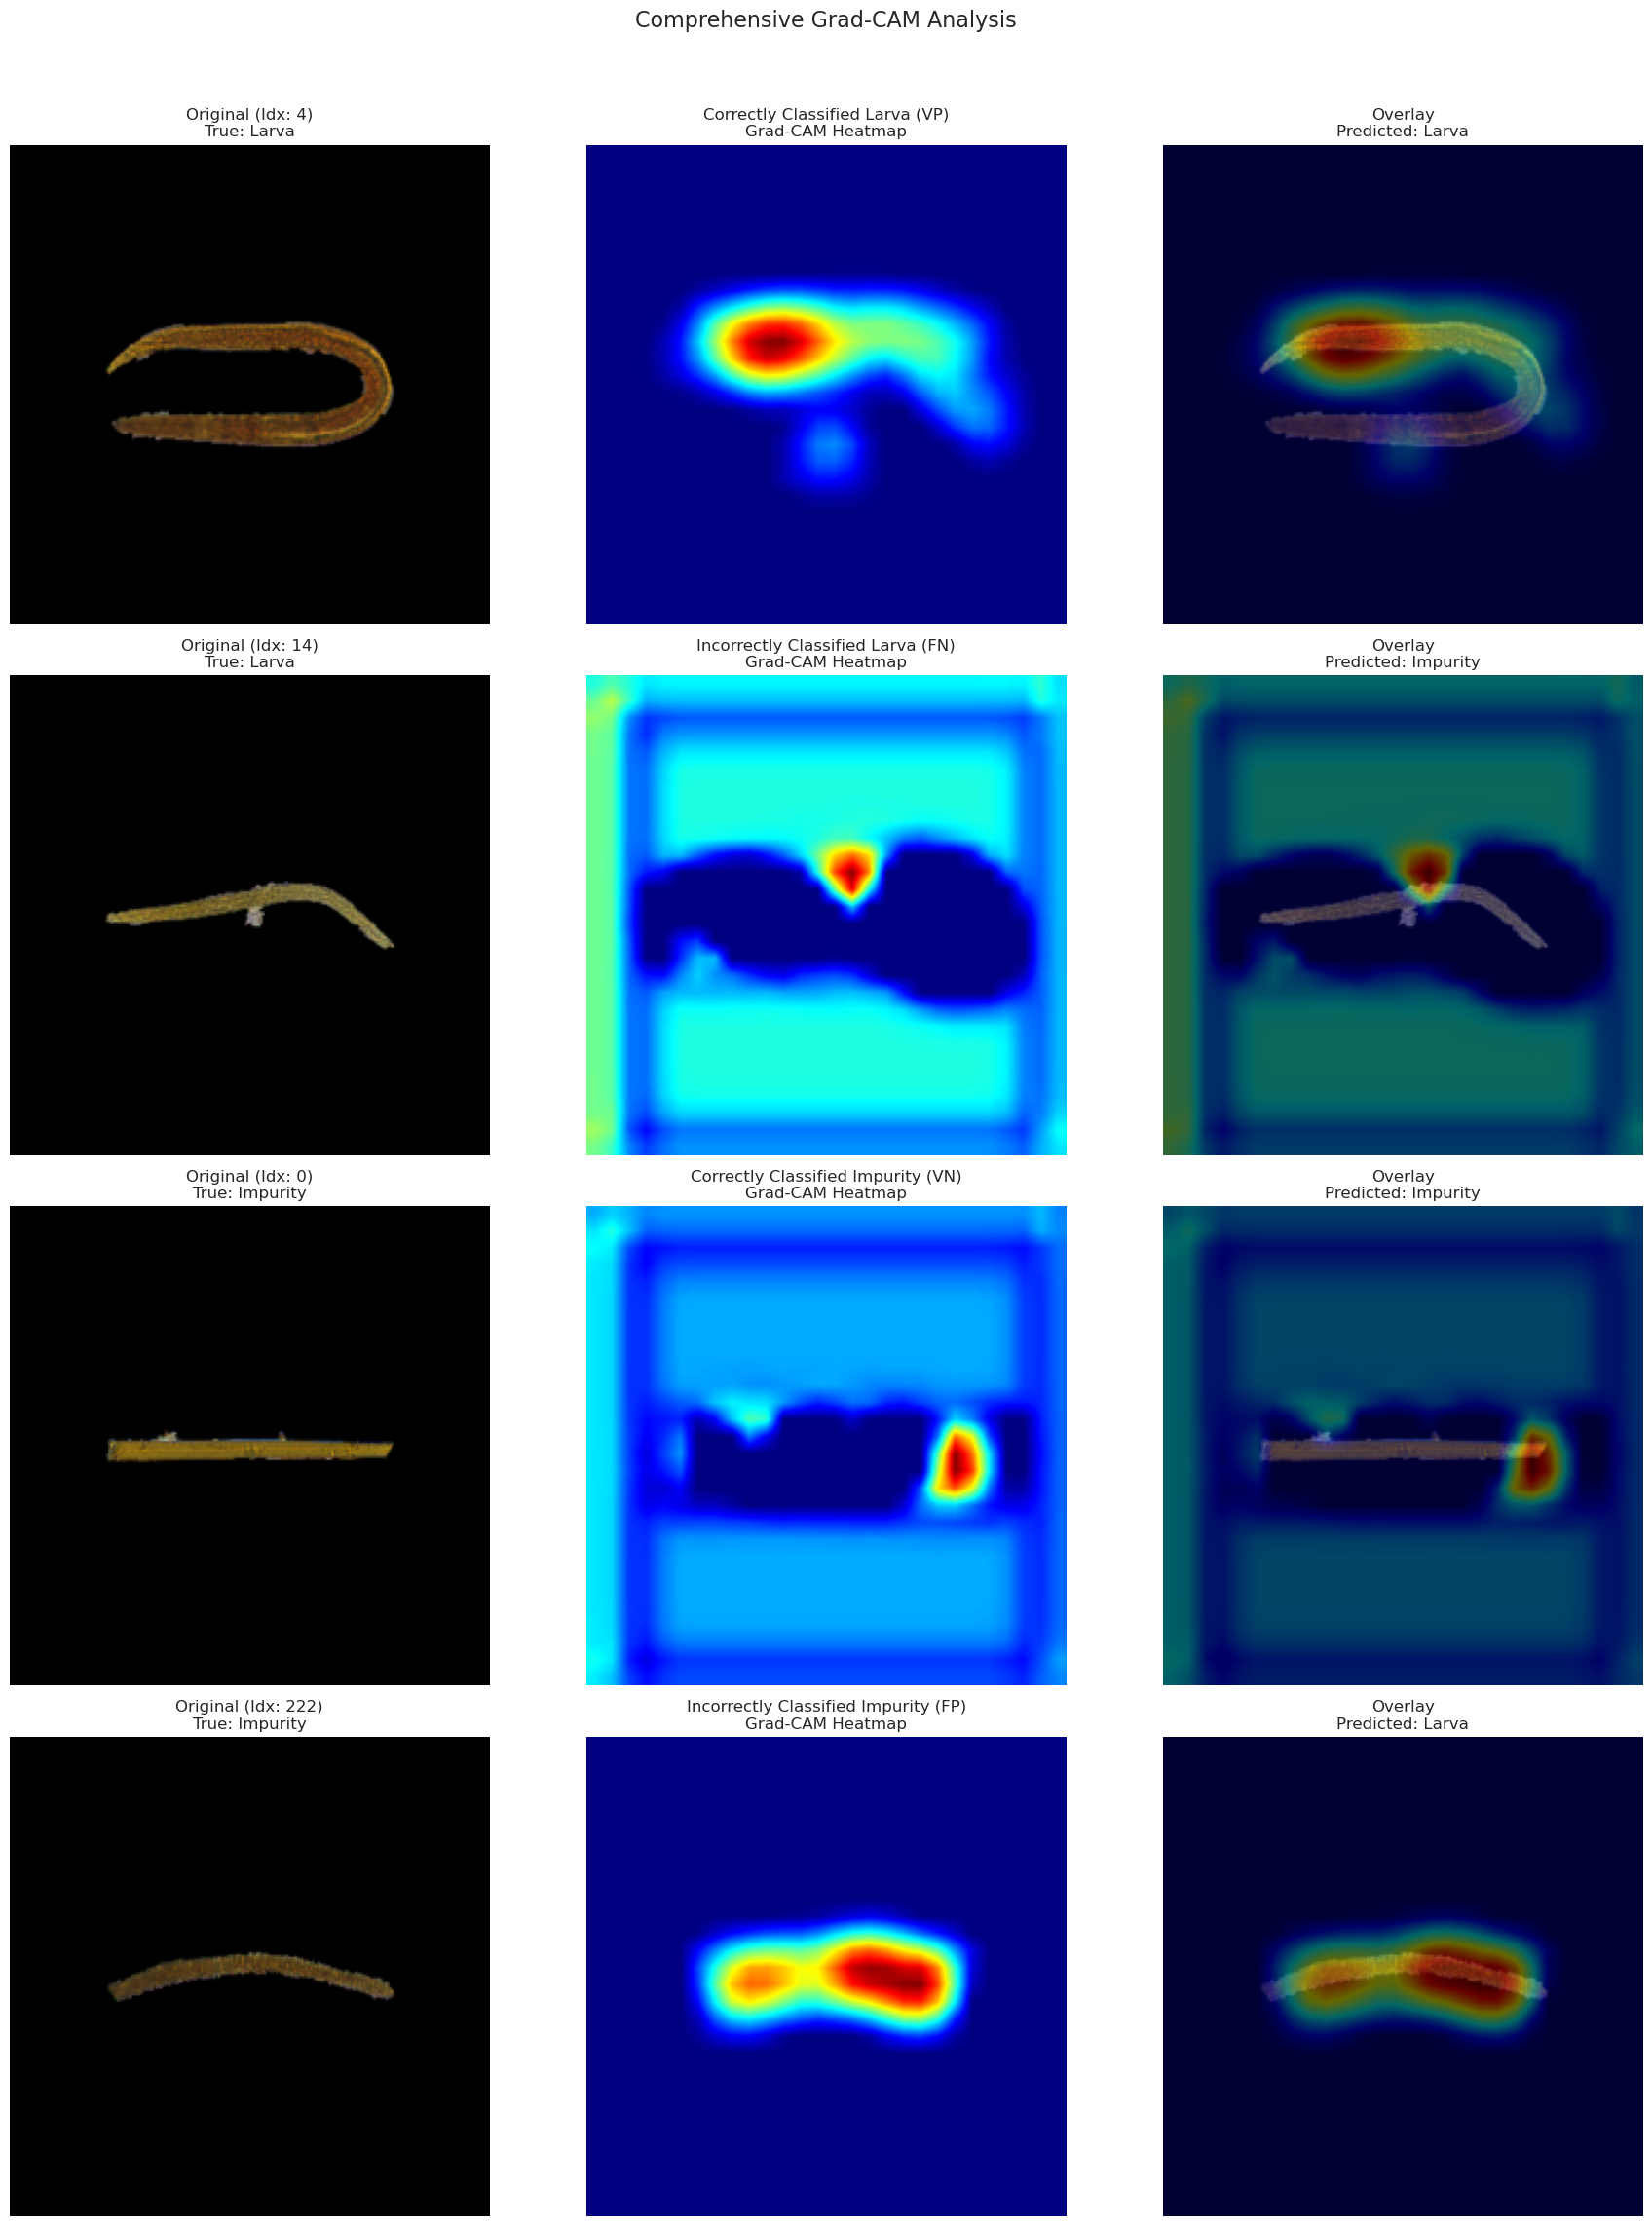

In [47]:
target_layer = model_v5.inception3
grad_cam = GradCAM(model_v5, target_layer)
class_names = {0: 'Larva', 1: 'Impurity'}

# Create a 4x3 grid for the plots
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
fig.suptitle('Comprehensive Grad-CAM Analysis', fontsize=16)

# Helper function to avoid code repetition
def plot_case(ax_row, case_idx, case_title):
    if case_idx == -1:
        print(f"Could not find an example for: {case_title}")
        ax_row[0].set_title(f"Example not found for\n{case_title}")
        for ax in ax_row: ax.axis('off')
        return

    img_tensor, label = testset[case_idx]
    orig_image_np = denormalize(img_tensor)

    cam, output = grad_cam(img_tensor.unsqueeze(0).to(device))
    pred_label = torch.argmax(output, dim=1).item()
    overlay, heatmap = visualize_gradcam(orig_image_np, cam)

    ax_row[0].imshow(orig_image_np)
    ax_row[0].set_title(f'Original (Idx: {case_idx})\nTrue: {class_names[label]}')
    ax_row[1].imshow(heatmap)
    ax_row[1].set_title('Grad-CAM Heatmap')
    ax_row[2].imshow(overlay)
    ax_row[2].set_title(f'Overlay\nPredicted: {class_names[pred_label]}')

# Plot all 4 cases
plot_case(axes[0], tp_idx, "True Positive")
plot_case(axes[1], fn_idx, "False Negative")
plot_case(axes[2], tn_idx, "True Negative")
plot_case(axes[3], fp_idx, "False Positive")

# Add overall titles for rows
axes[0, 1].set_title("Correctly Classified Larva (VP)\n" + axes[0, 1].get_title(), fontsize=12)
axes[1, 1].set_title("Incorrectly Classified Larva (FN)\n" + axes[1, 1].get_title(), fontsize=12)
axes[2, 1].set_title("Correctly Classified Impurity (VN)\n" + axes[2, 1].get_title(), fontsize=12)
axes[3, 1].set_title("Incorrectly Classified Impurity (FP)\n" + axes[3, 1].get_title(), fontsize=12)


for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

Running UMAP for 'UMAP Projection of the Last Inception Module (model_v5)'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


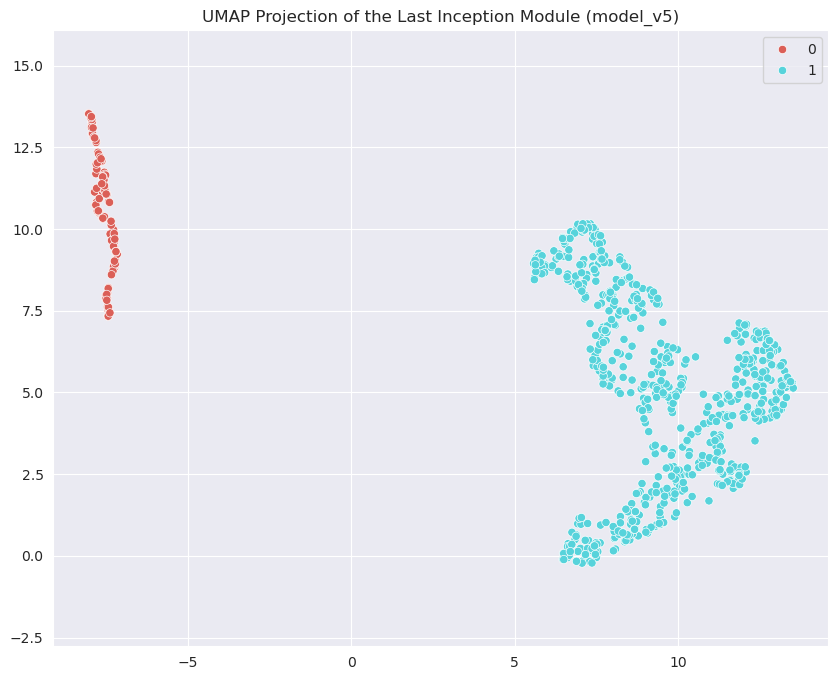

Running UMAP for 'UMAP Projection of the Final Feature Vector (model_v5)'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


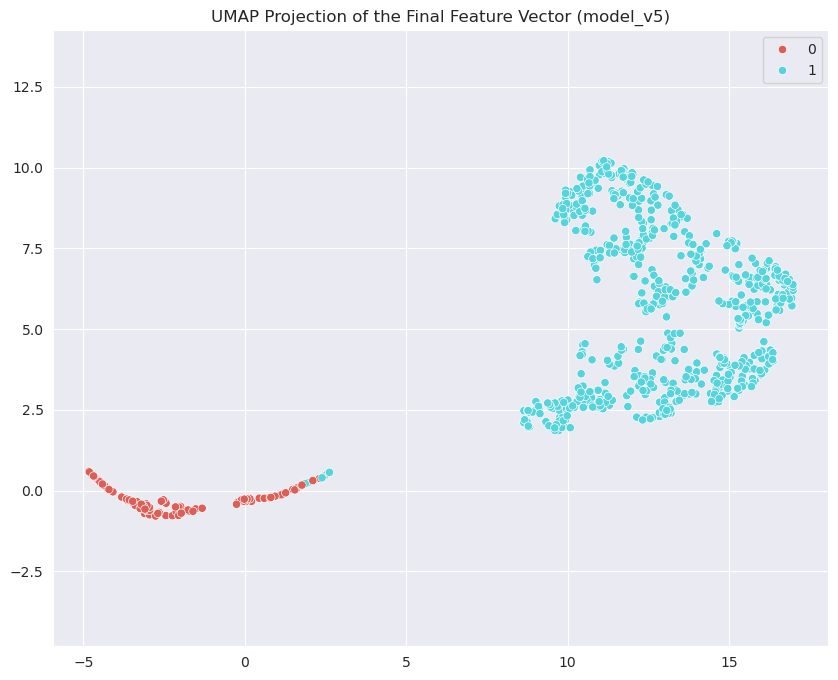

In [50]:
conv_features_v5, labels_v5 = extract_features(model_v5, trainload, 'inception3')
plot_projections(conv_features_v5, labels_v5, 'UMAP Projection of the Last Inception Module (model_v5)')

dense_features_v5, labels_v5 = extract_features(model_v5, trainload, 'avgpool')
plot_projections(dense_features_v5, labels_v5, 'UMAP Projection of the Final Feature Vector (model_v5)')

Plotting results...


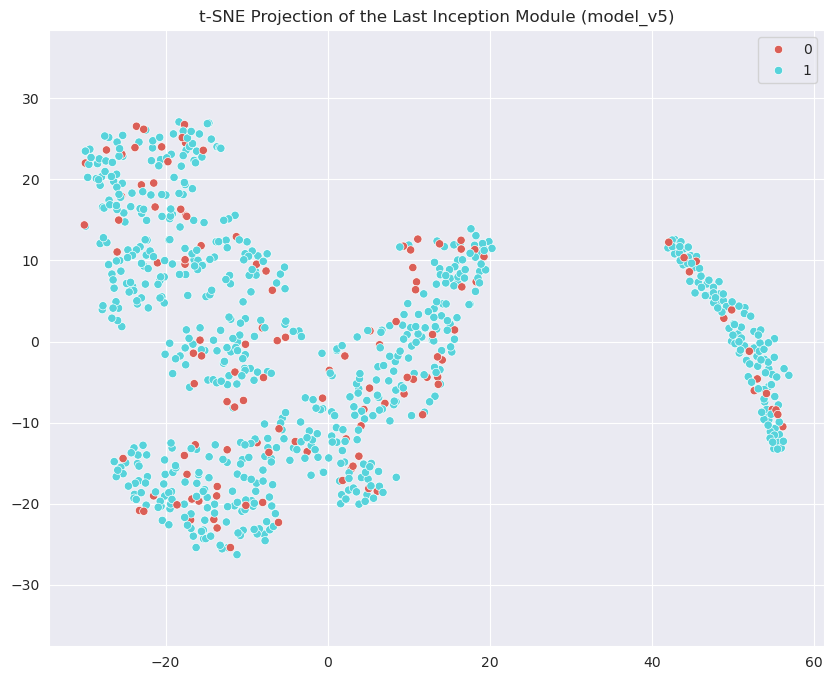

Plotting results...


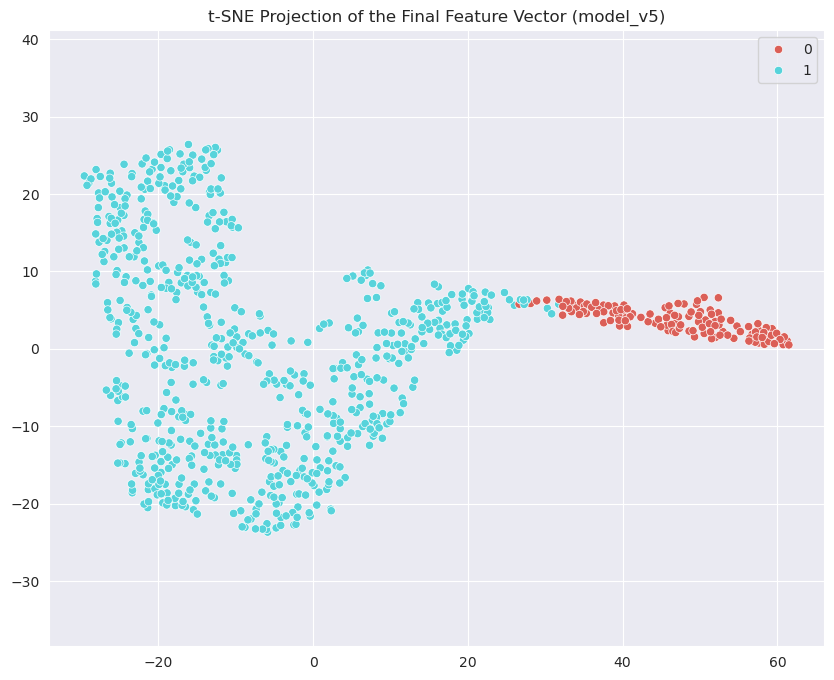

In [51]:
plot_tsne_projections(conv_features_v5, labels_v5, 't-SNE Projection of the Last Inception Module (model_v5)')
plot_tsne_projections(dense_features_v5, labels_v5, 't-SNE Projection of the Final Feature Vector (model_v5)')

In [50]:
# torch.save(model_v3.to('cpu').state_dict(), model_name)

# Transfer Learning

## VGG-16

In [8]:
model_vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)


# and set requires_grad = False freezes the layers.
for param in model_vgg.features.parameters():
    param.requires_grad = False

# get the number of input features for the last layer
num_features = model_vgg.classifier[6].in_features

#create a new final layer for our binary classification problem
new_final_layer = nn.Linear(num_features, nclasses)

# replace the original final layer with our new one
model_vgg.classifier[6] = new_final_layer

model_vgg = model_vgg.to(device)


# only pass the parameters of the classifier to the optimizer.
optimizer_vgg = optim.Adam(model_vgg.classifier.parameters(), lr=1e-4)
lr_scheduler_vgg = torch.optim.lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)



summary(model_vgg, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
trained_model_vgg, log_vgg = train_model(
    model=model_vgg,
    optimizer=optimizer_vgg,
    scheduler=lr_scheduler_vgg,
    criterion=criterion,
    train_loader=trainload,
    val_loader=validload,
    device=device,
    n_epochs=50,
    patience=20
)

--- Starting Training ---
EPOCH: 5.000  val_kappa: 0.832  (73.46s - 661.16s remaining)EPOCH: 5   Trn_Loss: 0.1072   Trn_Acc: 0.9748   Val_Loss: 0.1361   Val_Acc: 0.9531   Val_Kappa: 0.8318   Patience: 0/20
EPOCH: 10.000  val_kappa: 0.837  (148.18s - 592.71s remaining)EPOCH: 10   Trn_Loss: 0.0558   Trn_Acc: 0.9925   Val_Loss: 0.1378   Val_Acc: 0.9594   Val_Kappa: 0.8366   Patience: 2/20
EPOCH: 15.000  val_kappa: 0.892  (220.87s - 515.37s remaining)EPOCH: 15   Trn_Loss: 0.0535   Trn_Acc: 0.9975   Val_Loss: 0.1345   Val_Acc: 0.9719   Val_Kappa: 0.8925   Patience: 7/20
EPOCH: 20.000  val_kappa: 0.892  (294.17s - 441.25s remaining)EPOCH: 20   Trn_Loss: 0.0605   Trn_Acc: 0.9899   Val_Loss: 0.1353   Val_Acc: 0.9719   Val_Kappa: 0.8925   Patience: 12/20
EPOCH: 25.000  val_kappa: 0.892  (367.50s - 367.50s remaining)EPOCH: 25   Trn_Loss: 0.0640   Trn_Acc: 0.9912   Val_Loss: 0.1358   Val_Acc: 0.9719   Val_Kappa: 0.8925   Patience: 17/20
EPOCH: 27.000  val_kappa: 0.892  (396.67s - 337.91s remainin

100%|██████████| 151/151 [00:00<00:00, 14205.86it/s]


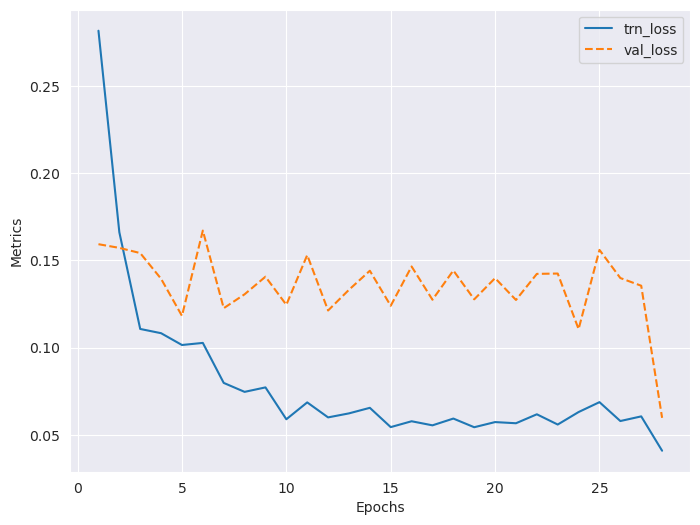

100%|██████████| 151/151 [00:00<00:00, 17599.62it/s]


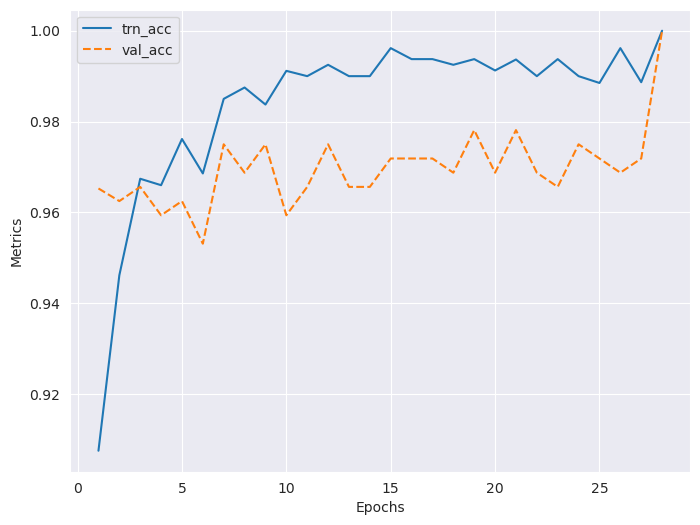

In [17]:
log_vgg.plot_epochs(['trn_loss','val_loss'])
log_vgg.plot_epochs(['trn_acc','val_acc'])

In [18]:
# The function now returns three values
(loss, acc, kappa) = Test(trained_model_vgg, testload, criterion, device)

print('Test Results -> Loss: {:.6f}  Acc: {:.6f}  Kappa: {:.6f}'.format(loss, acc, kappa))

Test Results -> Loss: 0.135918  Acc: 0.966667  Kappa: 0.869299


### Evaluating

Running UMAP for 'UMAP Projection of the VGG-16 Feature Extractor'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


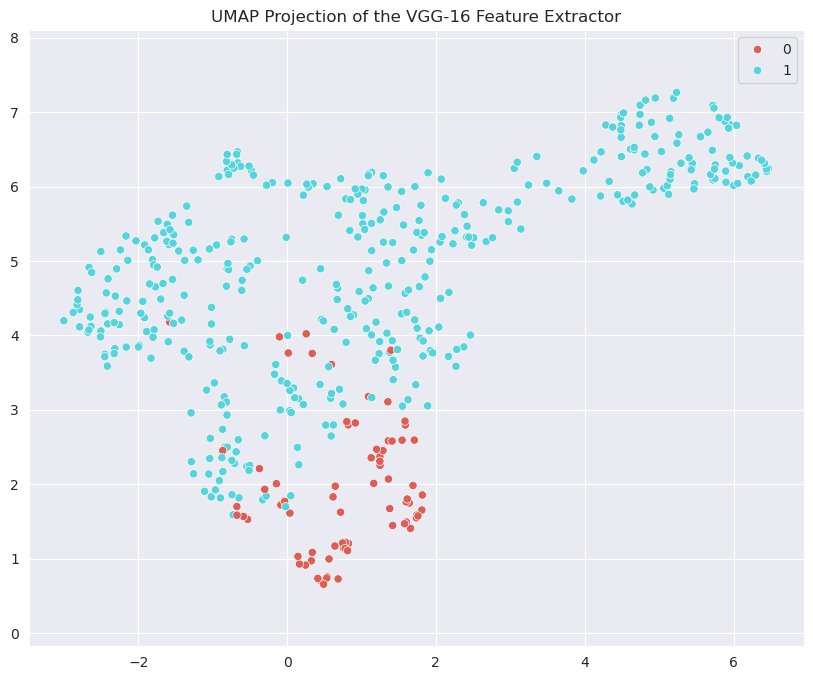

Running UMAP for 'UMAP Projection of the First Dense Layer (VGG-16)'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


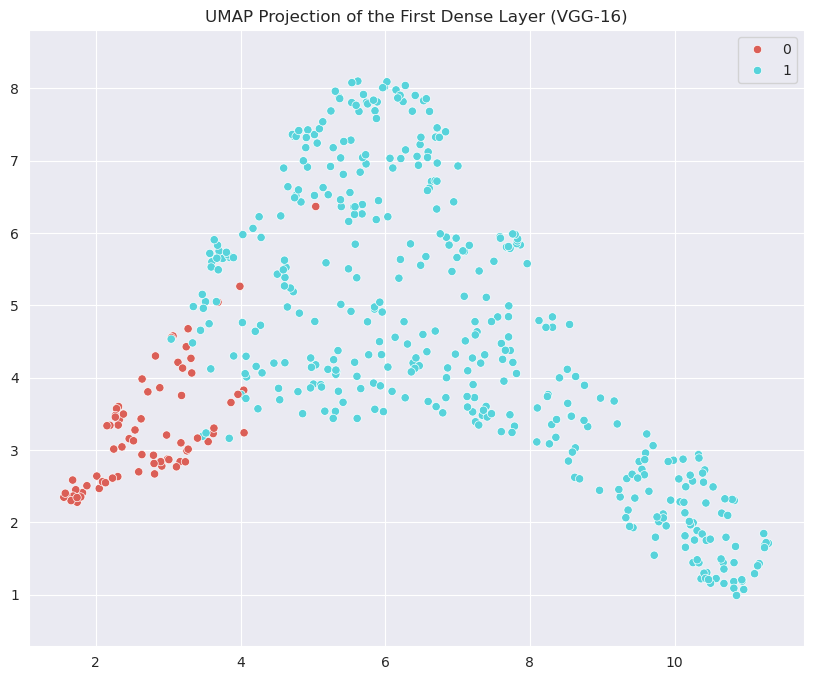

In [19]:
conv_features_vgg, labels_vgg = extract_features(model_vgg, testload, 'features')
plot_projections(conv_features_vgg, labels_vgg, 'UMAP Projection of the VGG-16 Feature Extractor')

dense_features_vgg, labels_vgg = extract_features(model_vgg, testload, 'classifier.1')
plot_projections(dense_features_vgg, labels_vgg, 'UMAP Projection of the First Dense Layer (VGG-16)')

Plotting results...


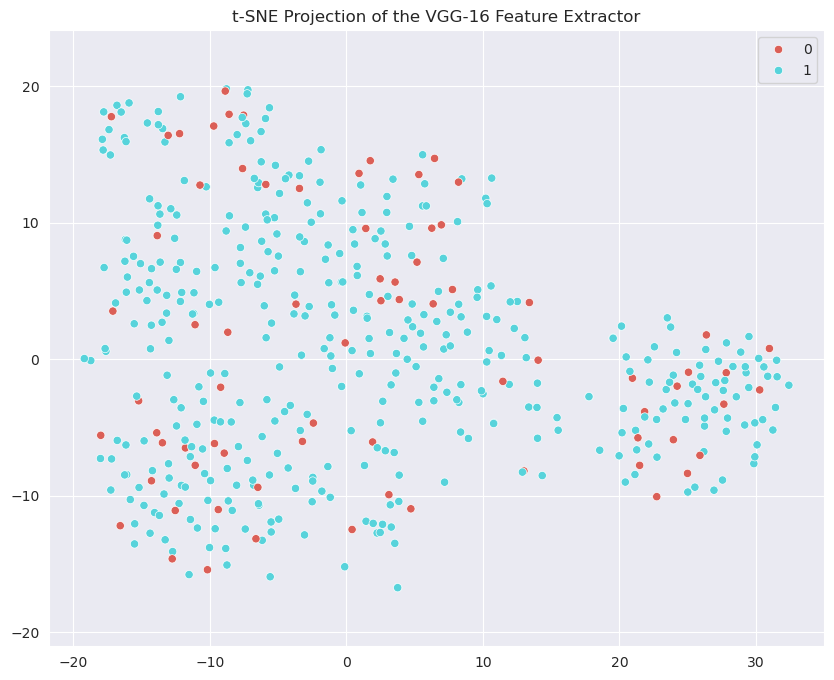

Plotting results...


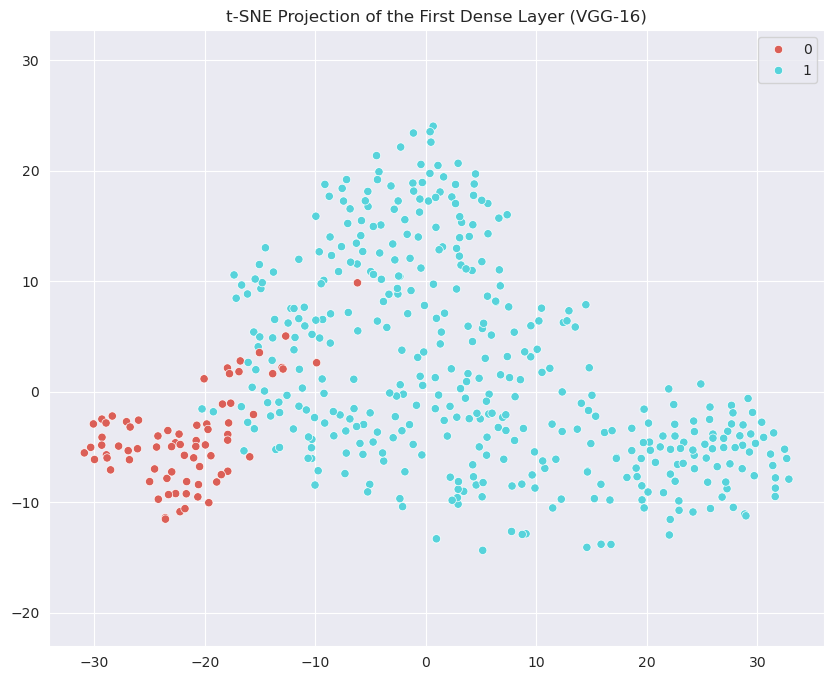

In [20]:
plot_tsne_projections(conv_features_vgg, labels_vgg, 't-SNE Projection of the VGG-16 Feature Extractor')
plot_tsne_projections(dense_features_vgg, labels_vgg, 't-SNE Projection of the First Dense Layer (VGG-16)')

In [21]:
# torch.save(model_vgg.to('cpu').state_dict(), 'vgg.pth')

## Resnet-50

In [23]:
model_resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model_resnet.parameters():
    param.requires_grad = False

num_features = model_resnet.fc.in_features

model_resnet.fc = nn.Linear(num_features, nclasses)

model_resnet = model_resnet.to(device)
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=1e-4)
lr_scheduler_resnet = torch.optim.lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

summary(model_resnet, input_shape)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/kdunorat/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 37.5MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [24]:
trained_model_resnet, log_resnet = train_model(
    model=model_resnet,
    optimizer=optimizer_resnet,
    scheduler=lr_scheduler_resnet,
    criterion=criterion,
    train_loader=trainload,
    val_loader=validload,
    device=device,
    n_epochs=50,
    patience=20
)

--- Starting Training ---
EPOCH: 5.000  val_kappa: 0.000  (39.84s - 358.60s remaining)EPOCH: 5   Trn_Loss: 0.9321   Trn_Acc: 0.8455   Val_Loss: 0.8925   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 0/20
EPOCH: 10.000  val_kappa: 0.000  (80.15s - 320.59s remaining)EPOCH: 10   Trn_Loss: 0.8936   Trn_Acc: 0.8458   Val_Loss: 0.8749   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 2/20
EPOCH: 15.000  val_kappa: 0.000  (120.32s - 280.75s remaining)EPOCH: 15   Trn_Loss: 0.8936   Trn_Acc: 0.8457   Val_Loss: 0.8699   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 1/20
EPOCH: 20.000  val_kappa: 0.000  (161.03s - 241.55s remaining)EPOCH: 20   Trn_Loss: 0.8845   Trn_Acc: 0.8459   Val_Loss: 0.8687   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 2/20
EPOCH: 25.000  val_kappa: 0.000  (201.29s - 201.29s remaining)EPOCH: 25   Trn_Loss: 0.8856   Trn_Acc: 0.8461   Val_Loss: 0.8666   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 7/20
EPOCH: 30.000  val_kappa: 0.000  (241.88s - 161.25s remaining)E

100%|██████████| 151/151 [00:00<00:00, 14542.82it/s]


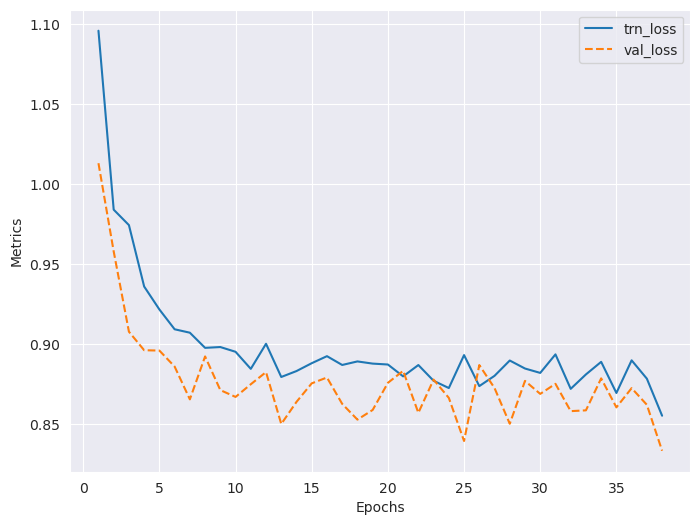

100%|██████████| 151/151 [00:00<00:00, 14170.58it/s]


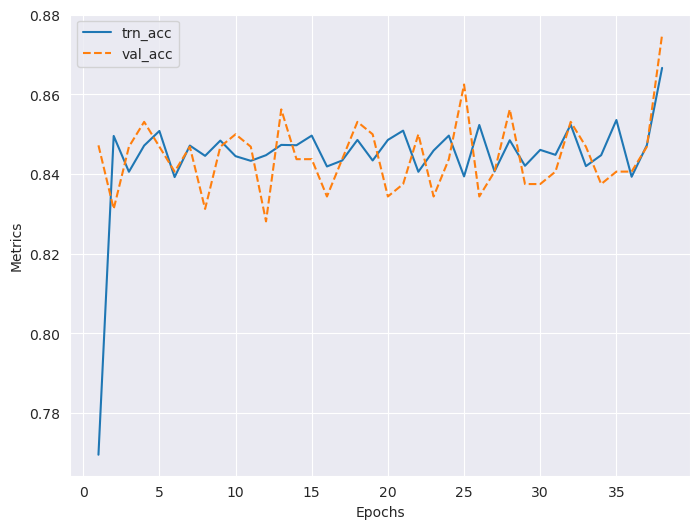

In [26]:
log_resnet.plot_epochs(['trn_loss','val_loss'])
log_resnet.plot_epochs(['trn_acc','val_acc'])

In [27]:
# The function now returns three values
(loss, acc, kappa) = Test(trained_model_resnet, testload, criterion, device)

print('Test Results -> Loss: {:.6f}  Acc: {:.6f}  Kappa: {:.6f}'.format(loss, acc, kappa))

Test Results -> Loss: 0.863174  Acc: 0.845833  Kappa: 0.000000


In [28]:
targets_tensor = torch.tensor(trainset.targets)

# Calcular as contagens e proporções
counts = torch.bincount(targets_tensor)
proportions = counts.float() / targets_tensor.size(0)

# Exibir os resultados
for i, (count, proportion) in enumerate(zip(counts, proportions)):
    print(f"Classe {i}: {count.item()} exemplos ({proportion.item() * 100:.2f}%)")

Classe 0: 123 exemplos (15.41%)
Classe 1: 675 exemplos (84.59%)


The model is predicting always the majoritarian class. We will do a fine tuning

In [10]:
model_resnet_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


for param in model_resnet_ft.parameters():
    param.requires_grad = False

num_features = model_resnet_ft.fc.in_features
model_resnet_ft.fc = nn.Linear(num_features, nclasses)
# we will unfreeze the weights of 'layer4' to allow for fine-tuning.
print("Unfreezing weights of the final convolutional block (layer4)...")
for param in model_resnet_ft.layer4.parameters():
    param.requires_grad = True


model_resnet_ft = model_resnet_ft.to(device)

# The optimizer now needs to update the parameters of both the classifier (.fc) and the unfrozen block (.layer4)
optimizer_resnet_ft = optim.Adam(
    list(model_resnet_ft.fc.parameters()) + list(model_resnet_ft.layer4.parameters()),
    lr=1e-5
)
lr_scheduler_resnet_ft = torch.optim.lr_scheduler.StepLR(optimizer_resnet_ft, step_size=7, gamma=0.1)


summary(model_resnet_ft, input_shape)

Unfreezing weights of the final convolutional block (layer4)...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256,

In [11]:
trained_model_resnet_ft, log_resnet_ft = train_model(
    model=model_resnet_ft,
    optimizer=optimizer_resnet_ft,
    scheduler=lr_scheduler_resnet_ft,
    criterion=criterion,
    train_loader=trainload,
    val_loader=validload,
    device=device,
    n_epochs=50,
    patience=20
)

--- Starting Training ---
EPOCH: 5.000  val_kappa: 0.000  (44.15s - 397.35s remaining)EPOCH: 5   Trn_Loss: 0.8013   Trn_Acc: 0.8459   Val_Loss: 0.7909   Val_Acc: 0.8438   Val_Kappa: 0.0000   Patience: 0/20
EPOCH: 10.000  val_kappa: 0.348  (87.83s - 351.33s remaining)EPOCH: 10   Trn_Loss: 0.7255   Trn_Acc: 0.8736   Val_Loss: 0.7347   Val_Acc: 0.8812   Val_Kappa: 0.3476   Patience: 2/20
EPOCH: 15.000  val_kappa: 0.443  (131.40s - 306.59s remaining)EPOCH: 15   Trn_Loss: 0.7089   Trn_Acc: 0.8934   Val_Loss: 0.7251   Val_Acc: 0.8938   Val_Kappa: 0.4426   Patience: 0/20
EPOCH: 20.000  val_kappa: 0.443  (175.18s - 262.76s remaining)EPOCH: 20   Trn_Loss: 0.6977   Trn_Acc: 0.9011   Val_Loss: 0.7234   Val_Acc: 0.8938   Val_Kappa: 0.4426   Patience: 5/20
EPOCH: 25.000  val_kappa: 0.420  (218.79s - 218.79s remaining)EPOCH: 25   Trn_Loss: 0.6964   Trn_Acc: 0.9049   Val_Loss: 0.7208   Val_Acc: 0.8906   Val_Kappa: 0.4197   Patience: 10/20
EPOCH: 30.000  val_kappa: 0.443  (262.47s - 174.98s remaining)

In [13]:
# del model_resnet_ft
# del trainload, validload, testload
# del trainset, validset, testset

100%|██████████| 151/151 [00:00<00:00, 5238.33it/s]


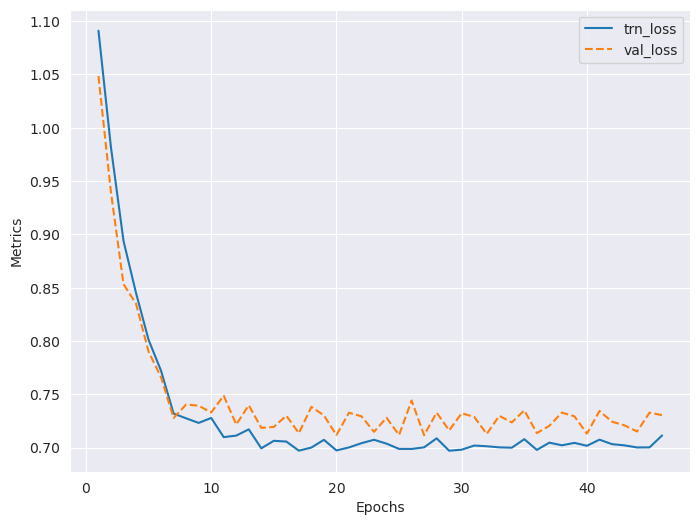

100%|██████████| 151/151 [00:00<00:00, 10630.79it/s]


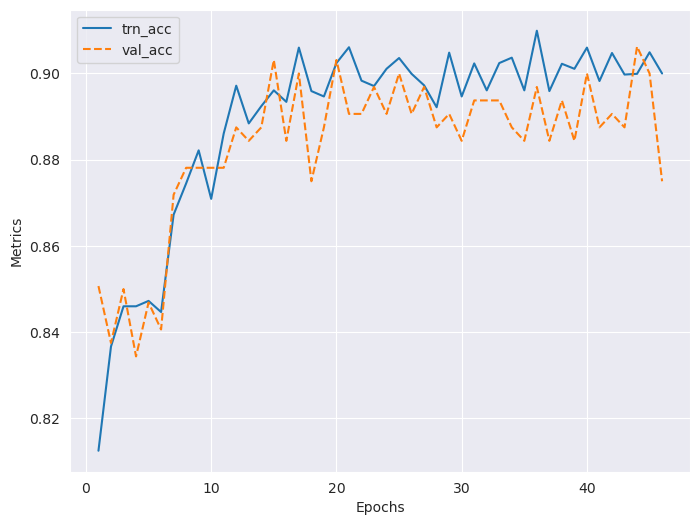

In [13]:
log_resnet_ft.plot_epochs(['trn_loss','val_loss'])
log_resnet_ft.plot_epochs(['trn_acc','val_acc'])

In [17]:
# The function now returns three values
(loss, acc, kappa) = Test(trained_model_resnet_ft, testload, criterion, device)

print('Test Results -> Loss: {:.6f}  Acc: {:.6f}  Kappa: {:.6f}'.format(loss, acc, kappa))

Test Results -> Loss: 0.721002  Acc: 0.902083  Kappa: 0.492851


### Evaluating

Running UMAP for 'UMAP Projection of the Last Residual Block (ResNet-50)'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


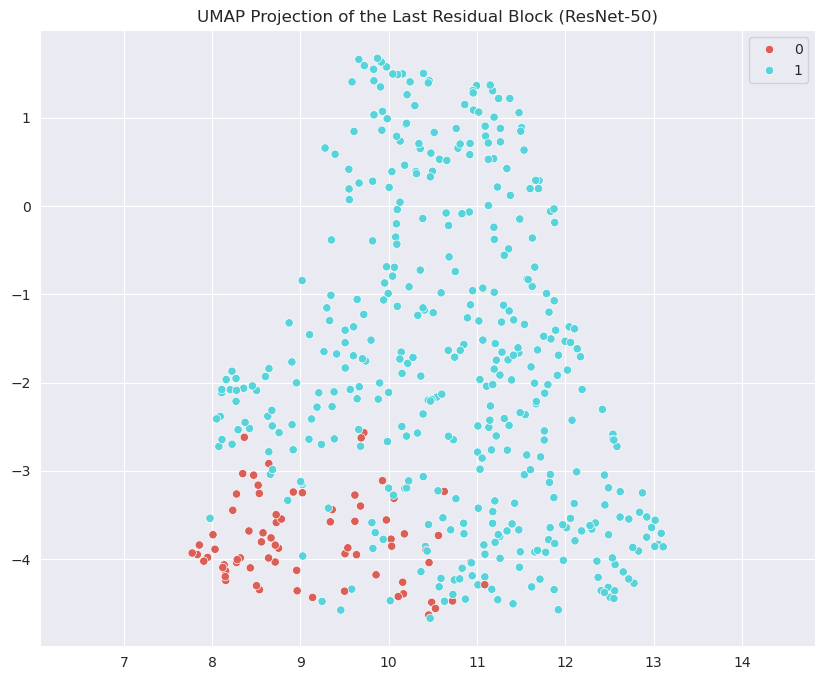

Running UMAP for 'UMAP Projection of the Final Feature Vector (ResNet-50)'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


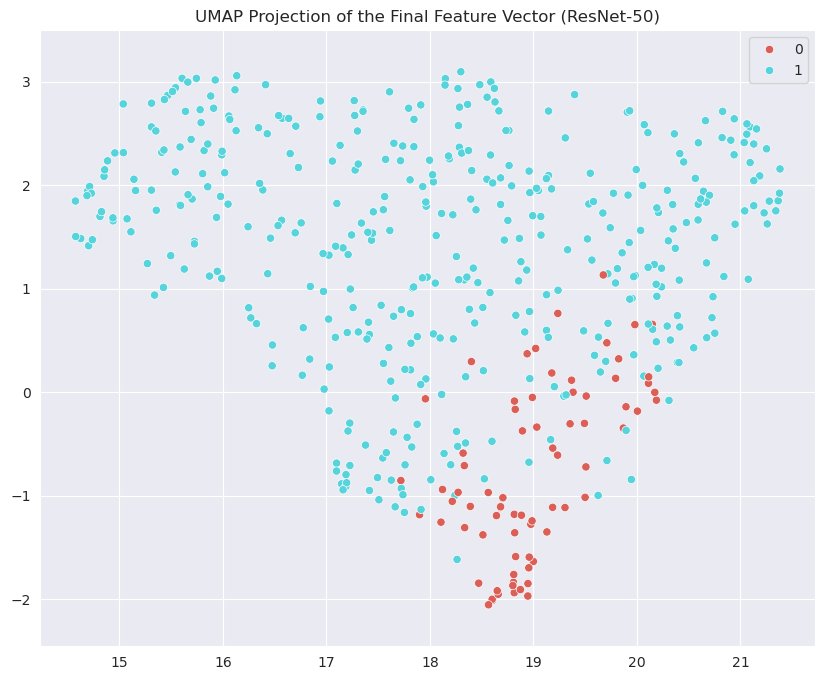

In [25]:
conv_features_resnet, labels_resnet = extract_features(model_resnet_ft, testload, 'layer4')
plot_projections(conv_features_resnet, labels_resnet, 'UMAP Projection of the Last Residual Block (ResNet-50)')
dense_features_resnet, labels_resnet = extract_features(model_resnet_ft, testload, 'avgpool')
plot_projections(dense_features_resnet, labels_resnet, 'UMAP Projection of the Final Feature Vector (ResNet-50)')

Plotting results...


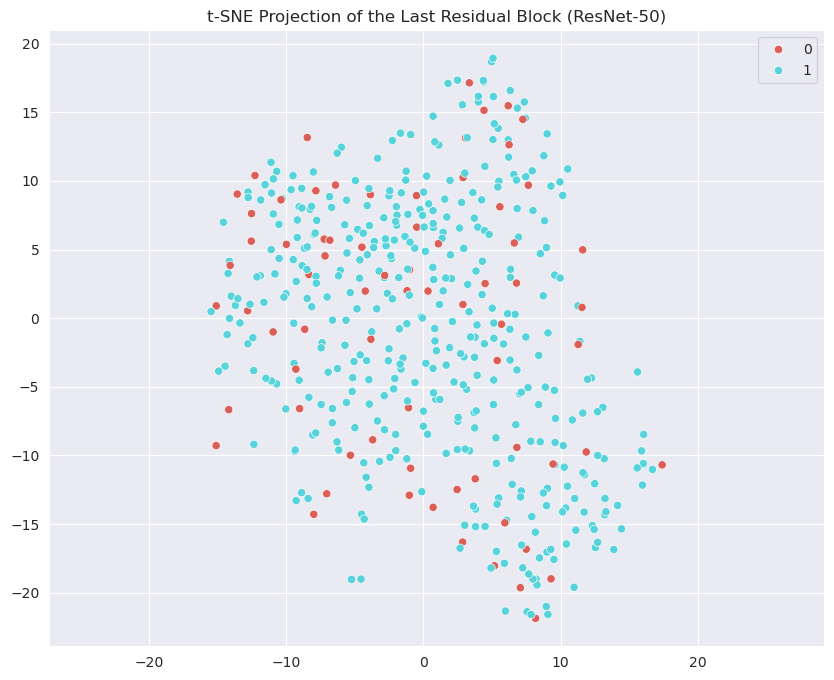

Plotting results...


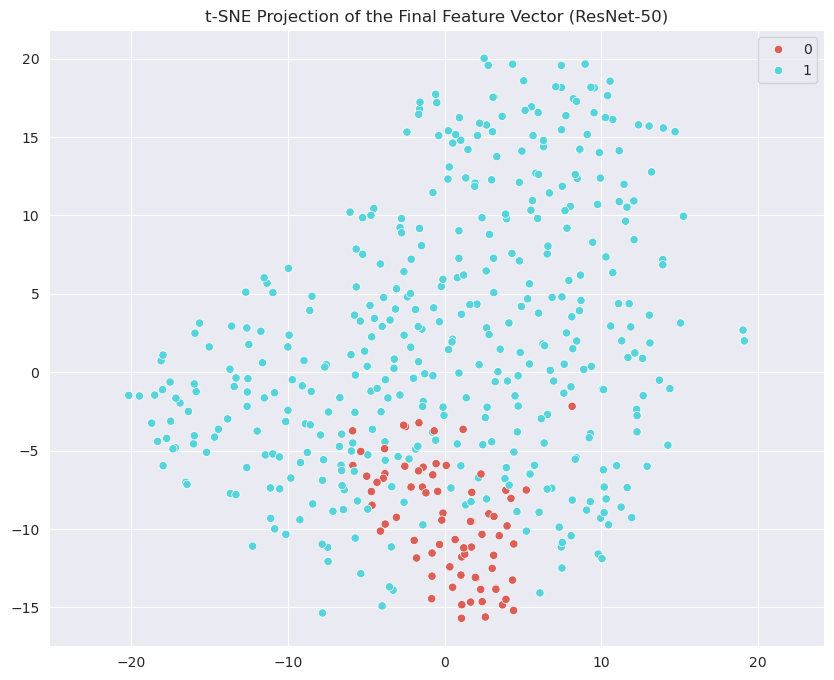

In [26]:
plot_tsne_projections(conv_features_resnet, labels_resnet, 't-SNE Projection of the Last Residual Block (ResNet-50)')
plot_tsne_projections(dense_features_resnet, labels_resnet, 't-SNE Projection of the Final Feature Vector (ResNet-50)')